# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# The first line of code loads the autoreload extension
# The second line of code sets the autoreload mode to automatically reload all modules before each execution
# Without autoreload, you would need to restart the kernel and re-import the module to see the changes
# We no longer need to restart the kernel, but we have to re-import the module. Is this the expected behaviour?
%load_ext autoreload
%autoreload 2

In [3]:
!pip install torchsummary
!pip install torch-lr-finder

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [11]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
  torch.cuda.manual_seed(SEED)
  device = torch.device("cuda")
  batch_size = 512
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  batch_size = 64
  print("Running on the CPU")


CUDA Available? True
Running on the GPU


In [13]:
from gdrive.MyDrive.utils import *

train_loader, test_loader = getDataLoader(batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


# View sample images

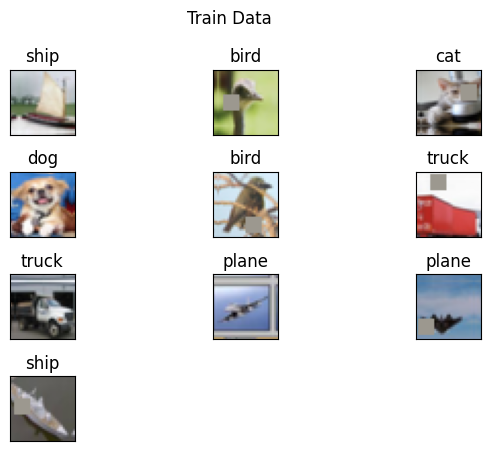

In [14]:
# getSampleImages(train_loader, num_images = 10) # Need to fix this function as it can take a maximum of 12 images only

# classes needs to be listed using cifar10.classes
getSampleImages(
    train_loader,
    10,
    "Train Data",
    classes=['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Model Params

In [15]:
from gdrive.MyDrive.model_customResNet import Net # Instead of import * because Net is in a conflict with something else,

model = Net().to(device)
getModelSummary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

# LR finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


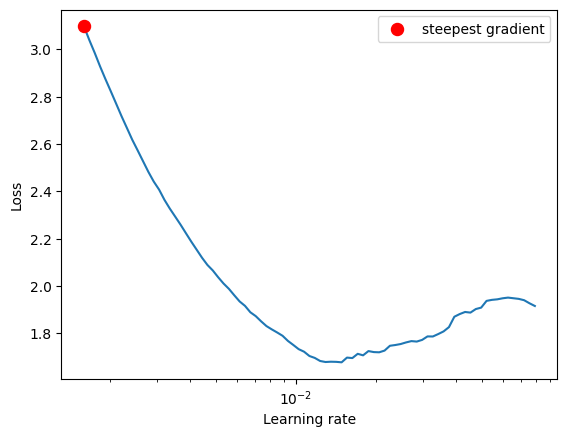

Min Loss = 1.6770620565107022, Max LR = 0.01484968262254465


In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()

# The model parameters are reset after this finishes
min_loss, max_lr = get_lr(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    end_lr=0.1,
    num_iter=100,
    step_mode="exp",
)

# Training and Testing

In [17]:
from torch.optim.lr_scheduler import OneCycleLR

'''
https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
Need to understand the calculations better to determine how to reach max_lr at 5th epoch
'''
num_epochs = 24
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,  # Technically, max_lr should be the the point before the steepest decrease or the point in between the steepest decrease
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=5 / num_epochs,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

train_losses, test_losses, train_acc, test_acc, lr_history = training(model, device, num_epochs, train_loader, test_loader, optimizer, criterion, scheduler=scheduler)

Epoch 1


Train: Loss=1.0144 Batch_id=97 Accuracy=50.44: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Test set: Average loss: 0.0025, Accuracy: 5920/10000 (59.20%)

Epoch 2


Train: Loss=0.8338 Batch_id=97 Accuracy=67.54: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]


Test set: Average loss: 0.0020, Accuracy: 6905/10000 (69.05%)

Epoch 3


Train: Loss=0.8445 Batch_id=97 Accuracy=72.82: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0021, Accuracy: 6985/10000 (69.85%)

Epoch 4


Train: Loss=0.6240 Batch_id=97 Accuracy=76.58: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Test set: Average loss: 0.0013, Accuracy: 7960/10000 (79.60%)

Epoch 5


Train: Loss=0.4709 Batch_id=97 Accuracy=79.26: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.0012, Accuracy: 8047/10000 (80.47%)

Epoch 6


Train: Loss=0.5164 Batch_id=97 Accuracy=82.30: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Test set: Average loss: 0.0011, Accuracy: 8227/10000 (82.27%)

Epoch 7


Train: Loss=0.4204 Batch_id=97 Accuracy=85.72: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


Test set: Average loss: 0.0009, Accuracy: 8569/10000 (85.69%)

Epoch 8


Train: Loss=0.3700 Batch_id=97 Accuracy=87.08: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]


Test set: Average loss: 0.0009, Accuracy: 8538/10000 (85.38%)

Epoch 9


Train: Loss=0.3101 Batch_id=97 Accuracy=88.65: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0009, Accuracy: 8540/10000 (85.40%)

Epoch 10


Train: Loss=0.2608 Batch_id=97 Accuracy=89.94: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0007, Accuracy: 8793/10000 (87.93%)

Epoch 11


Train: Loss=0.2476 Batch_id=97 Accuracy=90.79: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.0008, Accuracy: 8806/10000 (88.06%)

Epoch 12


Train: Loss=0.2472 Batch_id=97 Accuracy=91.84: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.0007, Accuracy: 8860/10000 (88.60%)

Epoch 13


Train: Loss=0.1876 Batch_id=97 Accuracy=92.77: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]


Test set: Average loss: 0.0007, Accuracy: 8944/10000 (89.44%)

Epoch 14


Train: Loss=0.2021 Batch_id=97 Accuracy=93.36: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.0006, Accuracy: 8968/10000 (89.68%)

Epoch 15


Train: Loss=0.1605 Batch_id=97 Accuracy=93.92: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Test set: Average loss: 0.0007, Accuracy: 8968/10000 (89.68%)

Epoch 16


Train: Loss=0.1691 Batch_id=97 Accuracy=94.71: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Test set: Average loss: 0.0006, Accuracy: 9035/10000 (90.35%)

Epoch 17


Train: Loss=0.1874 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]


Test set: Average loss: 0.0006, Accuracy: 9091/10000 (90.91%)

Epoch 18


Train: Loss=0.1364 Batch_id=97 Accuracy=95.94: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Test set: Average loss: 0.0006, Accuracy: 9103/10000 (91.03%)

Epoch 19


Train: Loss=0.0592 Batch_id=97 Accuracy=96.56: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]


Test set: Average loss: 0.0006, Accuracy: 9143/10000 (91.43%)

Epoch 20


Train: Loss=0.1053 Batch_id=97 Accuracy=97.20: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Test set: Average loss: 0.0006, Accuracy: 9190/10000 (91.90%)

Epoch 21


Train: Loss=0.0696 Batch_id=97 Accuracy=97.53: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]


Test set: Average loss: 0.0006, Accuracy: 9198/10000 (91.98%)

Epoch 22


Train: Loss=0.0668 Batch_id=97 Accuracy=97.74: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Test set: Average loss: 0.0006, Accuracy: 9220/10000 (92.20%)

Epoch 23


Train: Loss=0.0683 Batch_id=97 Accuracy=98.30: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0006, Accuracy: 9238/10000 (92.38%)

Epoch 24


Train: Loss=0.0174 Batch_id=97 Accuracy=98.56: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Test set: Average loss: 0.0006, Accuracy: 9241/10000 (92.41%)



# Graphs

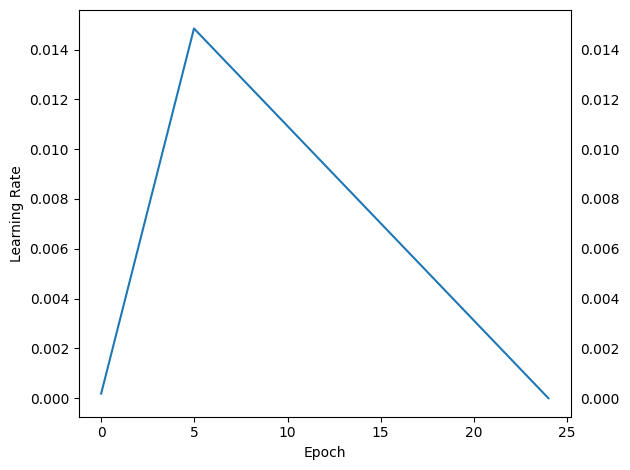

In [18]:
show_lr_history(lr_history, num_epochs)

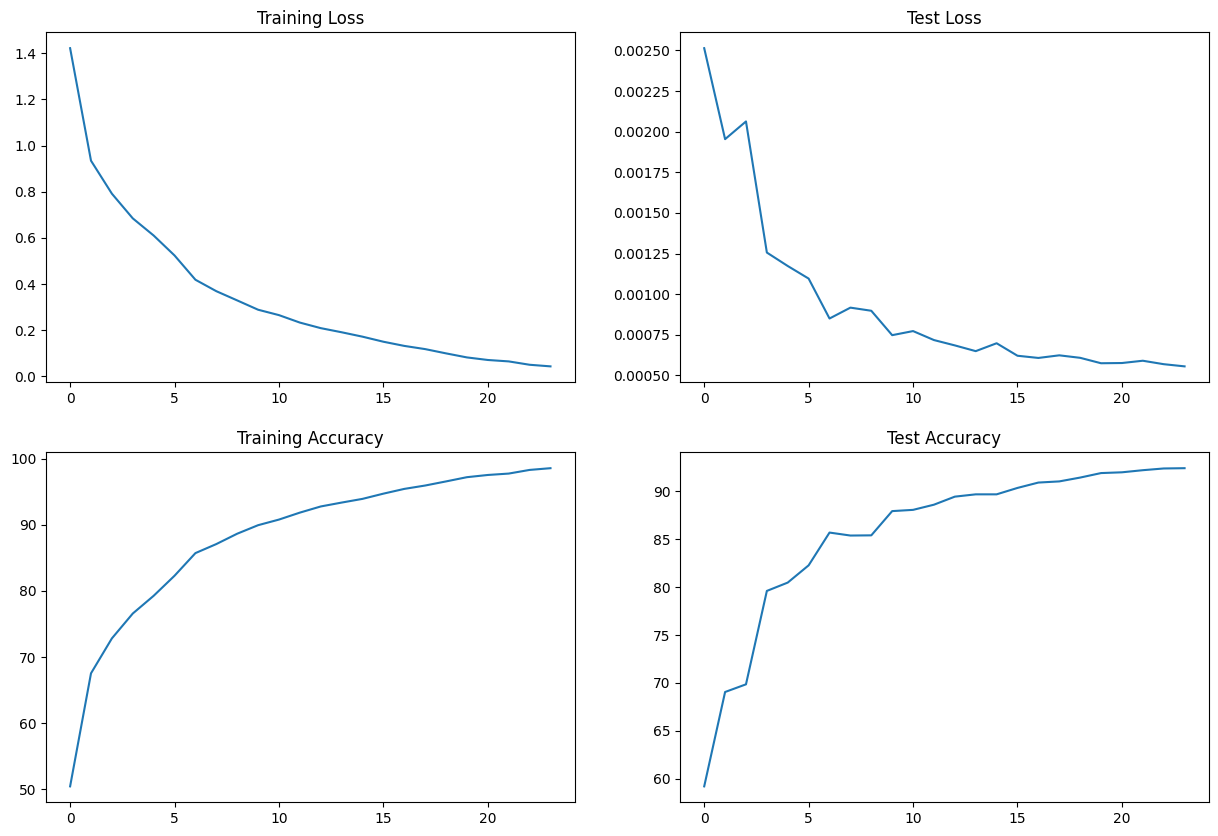

In [19]:
getTrainingTestPlots(train_losses, test_losses, train_acc, test_acc)

#  Misclassified images

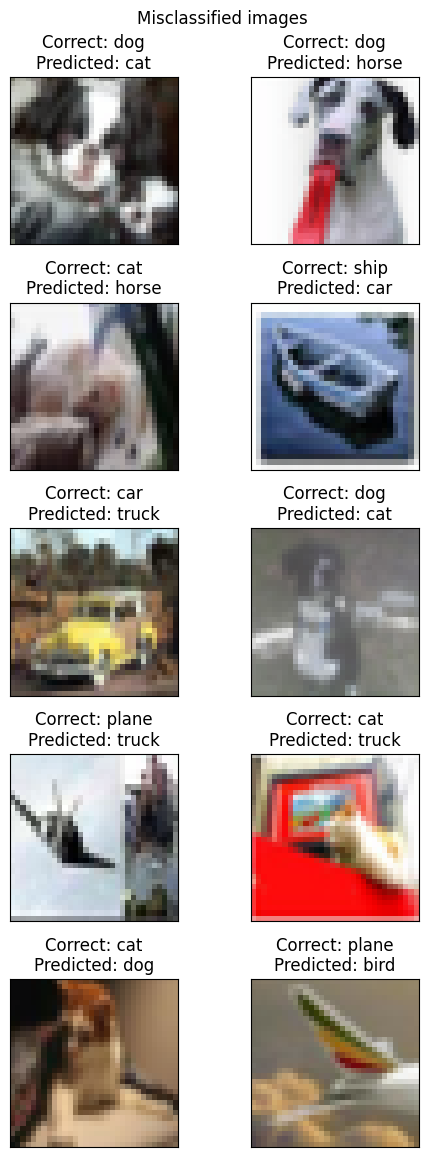

In [20]:
plot_misclassified_images(model, test_loader, ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], device)